In [1]:
#Phylogenetic tree construction for BNI taxa
#author: Sheng-Kai Hsu
#created: 2023.02.28
#last edited: 2023.11.27
#note: change to Paspalum reference
#note 6/15: change to miniProt-based Alignment
#note 11/27: re-use in p_phyloGWAS

In [1]:
rm(list=ls())

# library(rphast)
library(ape)
library(pheatmap)
library(limma)
library(parallel)
library(tidyverse)
library(ggtree)
# library(DescTools)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::where()  masks ape::where()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo        

In [2]:
# load metadata
metadata=read.csv("/workdir/coh22/poaceae_tfbs/data/Poaceae_metadata_2025.04.07_CH.csv",header = T)
metadata$spTaxa=paste0(metadata$assemblyID,": ",metadata$Species)

In [3]:
head(metadata)

assemblyID                         Species                Ecotype lifeHistory
1 A17                                Hordeum bulbosum       NA      perennial  
2 A42                                Hordeum bulbosum       NA      perennial  
3 aegilops_longissima_6782_assembly  Aegilops longissima    NA      annual     
4 aegilops_sharonensis_1644_assembly Aegilops sharonensis   NA      annual     
5 AN21TSTL0187                       Schizachyrium delavayi NA      perennial  
6 AN21TSTL0248                       Anatherum bicorne      NA      perennial  
  technology                              source tabasco_complete
1 Illumina Novaseq 6000; PacBio Sequel II NCBI   22              
2 Illumina Novaseq 6000; PacBio Sequel II NCBI   34              
3 NA                                      NCBI   4034            
4 NA                                      NCBI   4084            
5 Illumina                                PanAnd 4944            
6 Illumina                                PanAnd 1564            
  tabasco_duplicated tabasco_fraged tabasco_missing clade  subfamily  
1 5146               238            186             BOP    Pooideae   
2 5144               227            187             BOP    Pooideae   
3 1118               255            185             BOP    Pooideae   
4 1077               251            180             BOP    Pooideae   
5 336                311            1               PACMAD Panicoideae
6 3104               923            1               PACMAD Panicoideae
  tribe         subtribe      
1 Triticeae     Hordeinae     
2 Triticeae     Hordeinae     
3 Triticeae     Triticinae    
4 Triticeae     Triticinae    
5 Andropogoneae Anthistiriinae
6 Andropogoneae Andropogoninae
  spTaxa                                                  
1 A17: Hordeum bulbosum                                   
2 A42: Hordeum bulbosum                                   
3 aegilops_longissima_6782_assembly: Aegilops longissima  
4 aegilops_sharonensis_1644_assembly: Aegilops sharonensis
5 AN21TSTL0187: Schizachyrium delavayi                    
6 AN21TSTL0248: Anatherum bicorne

In [5]:
length(unique(metadata$Species))

[1] 589

In [2]:
#load 4d msa per transcript
fasta.4d.list=list.files("/workdir/sh2246/p_phyloGWAS/output/CDSMSAPerOG_4d/",".4d.fa$",full.names = T)
fasta.4d.aln=mclapply(fasta.4d.list,function(x) read.FASTA(x),mc.cores = 10)
fasta.4d.alnm=mclapply(fasta.4d.aln,function(x) as.matrix(x),mc.cores = 10)
# fasta.4d.alnm2=mclapply(fasta.4d.alnm,function(x) return(x[!rownames(x)%in%c("AN21TS40.final.contigs",
#                                                                              "AN21TS41.final.contigs",
#                                                                              "A1031001.final.contigs"),]),
#                         mc.cores = 10)


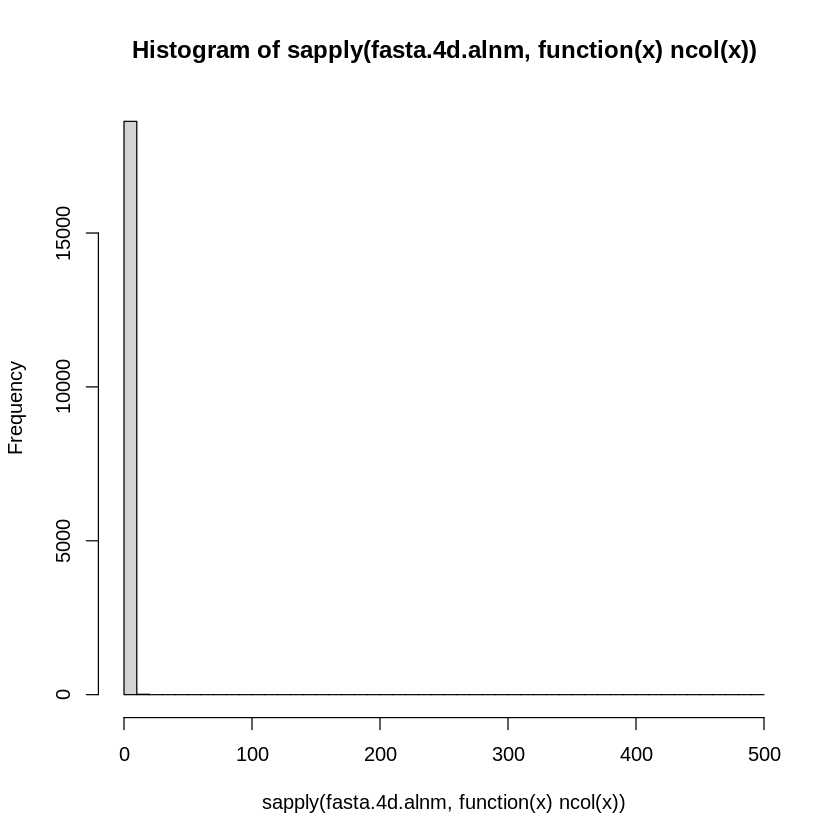

In [3]:
hist(sapply(fasta.4d.alnm,function(x) ncol(x)),breaks = seq(0,500,10))
fasta.4d.alnm = fasta.4d.alnm[sapply(fasta.4d.alnm,function(x) ncol(x))>0]

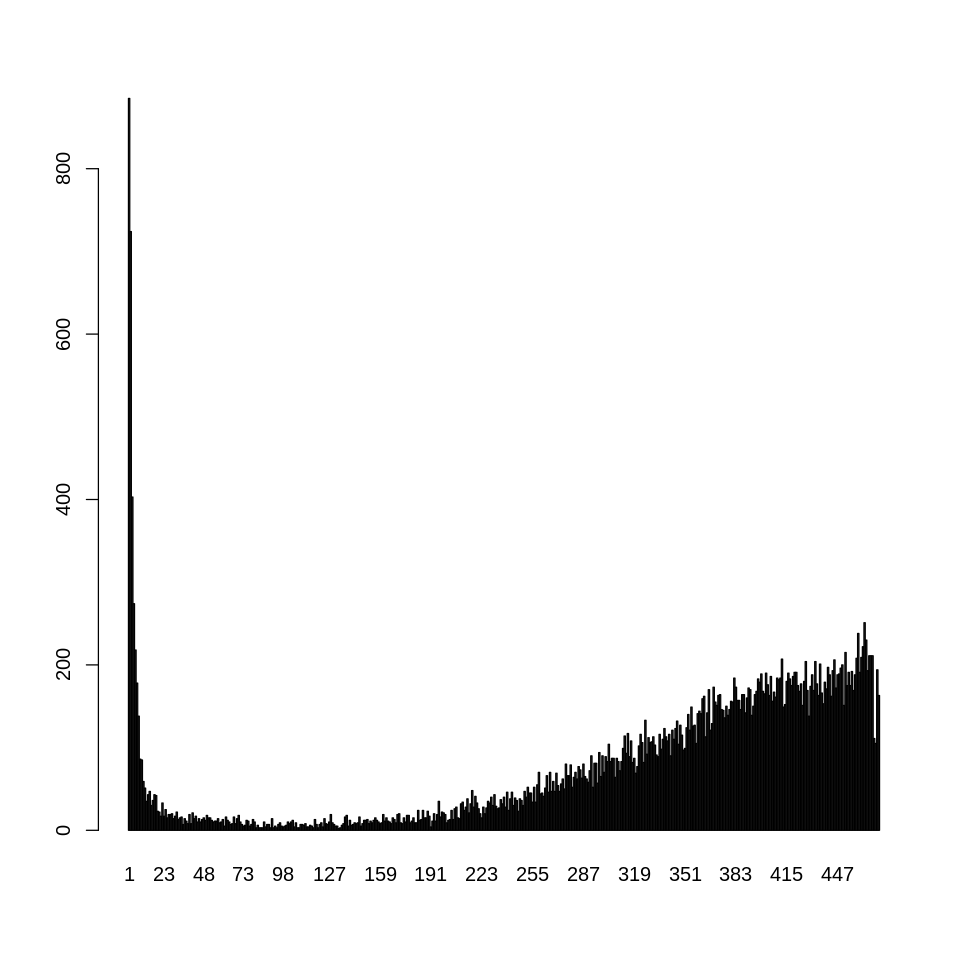

In [25]:
numTaxa=sapply(fasta.4d.alnm,nrow)
options(repr.plot.width=8, repr.plot.height=8)
barplot(table(numTaxa))

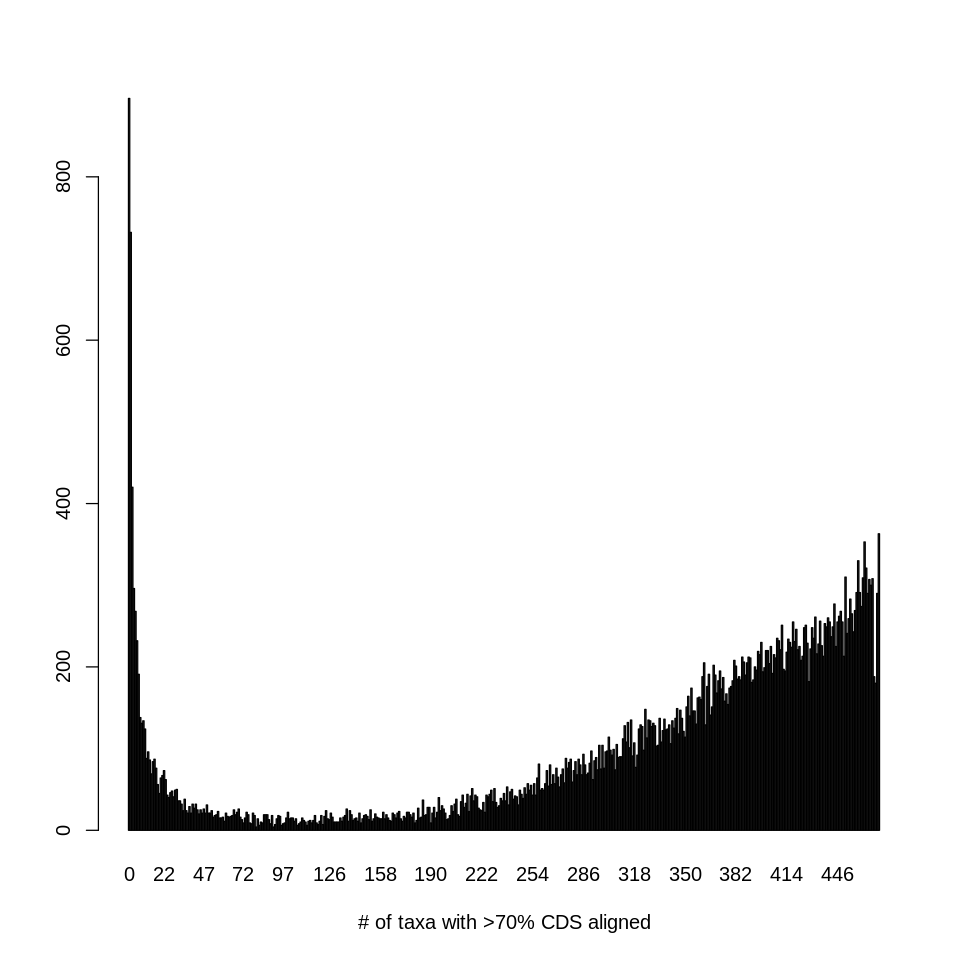

In [8]:
numTaxa.all = read.table("/workdir/sh2246/p_phyloGWAS/output/numMissingTaxa.txt",header = F)
barplot(table(472-numTaxa.all[,2]),xlab = "# of taxa with >70% CDS aligned")

In [9]:
out.df = numTaxa.all
out.df[,3] = 472-out.df[,2]

In [10]:
head(out.df)
# write.table(out.df,"/workdir/sh2246/p_phyloGWAS/output/numTaxa.txt",sep = "\t",row.names = F,quote = F)

V1                                                   V2  V3 
1 output/CDSPerOG_noATGFiltered/Pavag01G000100.1.fasta  43 429
2 output/CDSPerOG_noATGFiltered/Pavag01G000200.1.fasta  70 402
3 output/CDSPerOG_noATGFiltered/Pavag01G000200.2.fasta  58 414
4 output/CDSPerOG_noATGFiltered/Pavag01G000300.1.fasta 472   0
5 output/CDSPerOG_noATGFiltered/Pavag01G000300.2.fasta 472   0
6 output/CDSPerOG_noATGFiltered/Pavag01G000400.1.fasta 468   4

In [11]:
numTaxa.subset = read.table("/workdir/sh2246/p_phyloGWAS/output/numTaxa_497genesFromMichelle.txt",header = F)

In [12]:
options(repr.plot.width=8, repr.plot.height=8)
plot(table(numTaxa.subset[,3]),type = 'h',xlab = "# of taxa with >70% CDS aligned",ylab = "# of genes",
     xlim = c(0,472),xaxt='n')
axis(1,seq(0,500,50))
head(numTaxa.subset)

V1                                                   V2  V3 
1 output/CDSPerOG_noATGFiltered/Pavag01G004900.1.fasta  88 384
2 output/CDSPerOG_noATGFiltered/Pavag01G021000.1.fasta 200 272
3 output/CDSPerOG_noATGFiltered/Pavag01G025500.1.fasta 147 325
4 output/CDSPerOG_noATGFiltered/Pavag01G029600.1.fasta 101 371
5 output/CDSPerOG_noATGFiltered/Pavag01G031800.1.fasta 102 370
6 output/CDSPerOG_noATGFiltered/Pavag01G037200.1.fasta 175 297

In [26]:
# concat MSA for species tree construction
set.seed(123)
# idx = sample(which(numTaxa>300),5000)
# fasta.4d.alnm3 = fasta.4d.alnm[idx]
# fasta.4d.alnm = mclapply(fasta.4d.alnm3,function(x) {rownames(x)[grep("Pavag",rownames(x))] = "REF"; return(x)},mc.cores = 30)

In [27]:
fasta.4d.alnm2 = mclapply(fasta.4d.alnm,function(x) x[grep(":0$",rownames(x)),],mc.cores = 30)

In [ ]:
allTaxa = Reduce("union",lapply(fasta.4d.alnm2,function(x) strsplit2(rownames(x),":")[,2]))

In [24]:
length(unique(allTaxa))

[1] 800

In [28]:
fasta.4d.alnm2 = mclapply(fasta.4d.alnm2,function(x) {
    tmp = x
    rownames(tmp) = strsplit2(rownames(x),":")[,2]
    return(tmp)
},mc.cores = 30)

In [29]:
fasta.4d.alnm2[[1]]

798 DNA sequences in binary format stored in a matrix.

All sequences of same length: 1 

Labels:
10wheat_assembly_jagger
10wheat_assembly_lancer
10wheat_assembly_stanley
4AgS
A1010002
A1014002
...

Base composition:
    a     c     g     t 
0.159 0.043 0.796 0.003 
(Total: 798 bases)

In [28]:
# fasta.4d.list[idx[1]]
# fasta.4d.alnm[[idx[1]]]

[1] "/workdir/sh2246/p_phyloGWAS/output/MSAPerOG_4d//Pavag06G036300.1.4d.fa"

381 DNA sequences in binary format stored in a matrix.

All sequences of same length: 8 

Labels:
A1014002
A1015002
A1020001
A1021002
A1025002
A1030002
...

Base composition:
    a     c     g     t 
0.259 0.123 0.364 0.255 
(Total: 3.05 kb)

[1] 381

In [30]:
fasta.4d.alnm3 = mclapply(fasta.4d.alnm2,function(x) {
    missTaxa = setdiff(allTaxa,rownames(x))
    tmp = matrix(rep("-",ncol(x)*length(missTaxa)),nrow = length(missTaxa),ncol = ncol(x),byrow = T)
    rownames(tmp) = missTaxa
    tmp = as.matrix(as.DNAbin(tmp))
    out = rbind(x,tmp)
    if (ncol(out) > 20) out = out[allTaxa,sample(1:ncol(out),20)]
    return(out)
},mc.cores = 30)


In [ ]:
# fasta.4d.alnm2 = mclapply(fasta.4d.alnm,function(x) {
#     missTaxa = setdiff(allTaxa,rownames(x))
#     tmp = matrix(rep("-",ncol(x)*length(missTaxa)),nrow = length(missTaxa),ncol = ncol(x),byrow = T)
#     rownames(tmp) = missTaxa
#     tmp = as.matrix(as.DNAbin(tmp))
#     out = rbind(x,tmp)
# #     if (ncol(out) > 20) out = out[allTaxa,sample(1:ncol(out),20)]
#     return(out)
# },mc.cores = 30)


In [31]:
fasta.4d.alnm3[[1]]
# matrix(as.numeric(fasta.4d.alnm3[[1]]),473,8)

800 DNA sequences in binary format stored in a matrix.

All sequences of same length: 1 

Labels:
10wheat_assembly_jagger
10wheat_assembly_lancer
10wheat_assembly_stanley
4AgS
A1010002
A1014002
...

Base composition:
    a     c     g     t 
0.159 0.043 0.796 0.003 
(Total: 800 bases)

In [32]:
fasta.4d.aln.merged=do.call(cbind, fasta.4d.alnm3)
# fasta.4d.aln.merged=do.call(cbind, fasta.4d.alnm2)

In [34]:
dim(fasta.4d.aln.merged)
# rownames(fasta.4d.aln.merged) = gsub(".final.contigs","",rownames(fasta.4d.aln.merged))
# rownames(fasta.4d.aln.merged) = strsplit2(rownames(fasta.4d.aln.merged),"_")[,1]


[1]  800 2399

In [35]:
write.FASTA(fasta.4d.aln.merged,"/workdir/sh2246/p_phyloGWAS/output/aln_4d_800taxa.fasta")

In [2]:
#load msa per transcript of the angiosperm 353 loci (and everything now)
fasta.list=list.files("/workdir/sh2246/p_phyloGWAS/output/CDSMSAPerOG_gs",".gs.l0.fa$",full.names = T)
OGNames = gsub(".gs.l0.fa","",strsplit2(fasta.list,"/")[,7])
angio353 = read.table("/workdir/sh2246/p_phyloGWAS/output/angiosperm353ToOGName.txt",header = F)[,1]
fasta.list = fasta.list[substr(strsplit2(fasta.list,"/")[,7],1,9)%in%angio353]
fasta.aln=mclapply(fasta.list,function(x) read.FASTA(x),mc.cores = 5)
fasta.alnm=mclapply(fasta.aln,function(x) as.matrix(x),mc.cores = 2)


In [3]:
gc()

used      (Mb)  gc trigger (Mb)   max used  (Mb)  
Ncells   1887153 100.8   2877262   153.7   1968798  105.2
Vcells 128009761 976.7 193359534  1475.3 191096007 1458.0

In [6]:
length(fasta.alnm)

[1] 413

In [7]:
fasta.alnm2 = mclapply(fasta.alnm,function(x) x[grep(":0$",rownames(x)),],mc.cores = 30)

In [8]:
fasta.alnm2 = mclapply(fasta.alnm2,function(x) {
    tmp = x
    rownames(tmp) = strsplit2(rownames(x),":")[,2]
    return(tmp)
},mc.cores = 30)

In [7]:
# dir.create("/workdir/sh2246/p_phyloGWAS/output/geneTree_angiosperm353/")
dir.create("/workdir/sh2246/p_phyloGWAS/output/geneTree_allOGs/")
for (i in 1:length(fasta.alnm2)){
#     write.FASTA(fasta.alnm2[[i]],paste0("/workdir/sh2246/p_phyloGWAS/output/geneTree_angiosperm353/gene_",i,".fa"))
     write.FASTA(fasta.alnm2[[i]],paste0("/workdir/sh2246/p_phyloGWAS/output/geneTree_allOGs/",OGNames[i],".fa"))
}

In [17]:
allTaxa = Reduce("union",lapply(fasta.alnm2,rownames))

In [18]:
fasta.alnm3 = mclapply(fasta.alnm2,function(x) {
    missTaxa = setdiff(allTaxa,rownames(x))
    tmp = matrix(rep("-",ncol(x)*length(missTaxa)),nrow = length(missTaxa),ncol = ncol(x),byrow = T)
    rownames(tmp) = missTaxa
    tmp = as.matrix(as.DNAbin(tmp))
    out = rbind(x,tmp)
    if (ncol(out) > 20) out = out[allTaxa,sample(1:ncol(out),20)]
    return(out)
},mc.cores = 30)


In [19]:
fasta.aln.merged=do.call(cbind, fasta.alnm3)

In [20]:
nrow(fasta.aln.merged)

[1] 800

In [72]:
d.angio353 =dist.dna(fasta.aln.merged,pairwise.deletion = T,model = "K81",as.matrix = T)

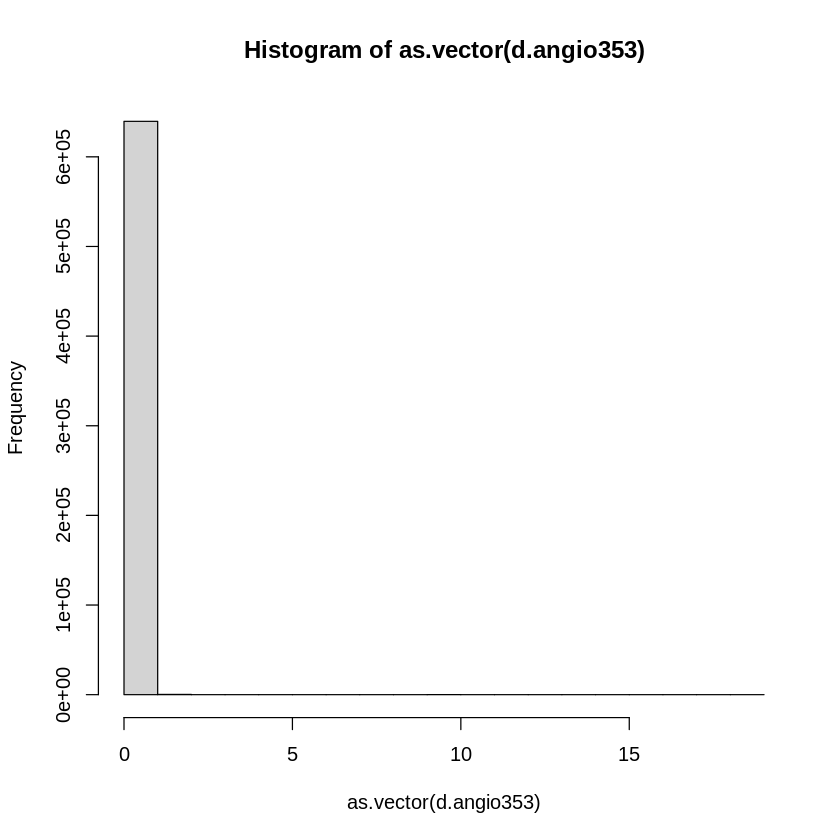

In [73]:
hist(as.vector(d.angio353))

In [74]:
d.angio353[d.angio353==Inf] = NA
d.angio353[d.angio353>=0.3] = NA

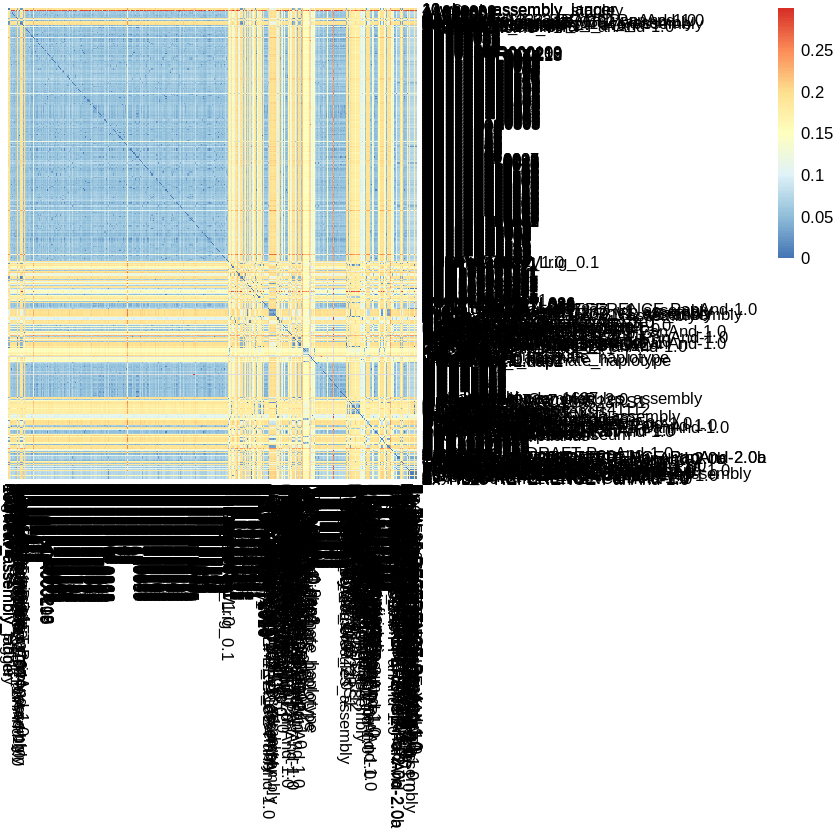

In [75]:
pheatmap(d.angio353,cluster_rows = F,cluster_cols = F)

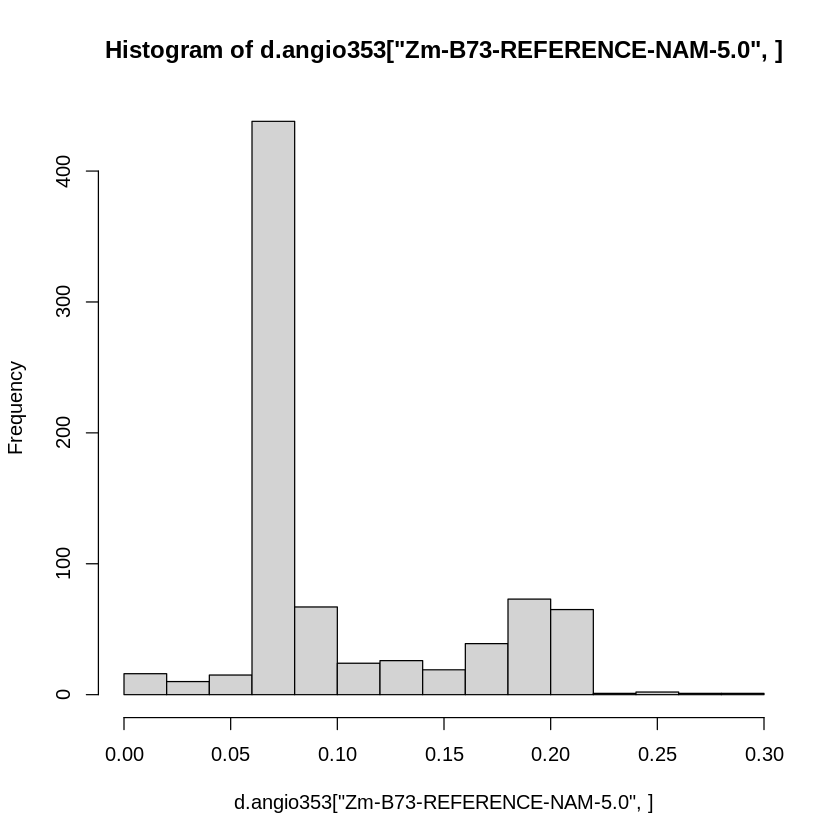

In [79]:
hist(d.angio353["Zm-B73-REFERENCE-NAM-5.0",])

In [84]:
write.table(d.angio353,"/workdir/sh2246/p_phyloGWAS/output/angiosperm353_geneticDistance.txt",col.names = T,row.names = F,quote = F,sep = "\t")

In [77]:
njtre.angio353 = ape::njs(d.angio353)

In [78]:
plot.phylo(root(njtre.angio353,"ASM1935983v1"),show.tip.label = F)

In [92]:
options(repr.plot.width=10, repr.plot.height=10)
hist(sapply(fasta.alnm2,dim)[2,])

In [97]:
dim(fasta.4d.aln.merged)

[1]  800 2399

In [ ]:
# local window neutral tree
names(fasta.4d.alnm)=gsub(".4d.fa","",strsplit2(fasta.4d.list,"/")[,8])

n=10
idx2 = list()
for (j in unique(substr(names(fasta.4d.alnm),1,8))){
    tmp = fasta.4d.alnm[grep(j,names(fasta.4d.alnm))]
    N=length(tmp)
    idx2[[j]] = c()
    for(i in 1:N){
        k = ceiling(n/2)
        if(i<k) idx2[[j]] = rbind(idx2[[j]],1:n)
        if(i>=k&i<=(N-n+k)) idx2[[j]] = rbind(idx2[[j]],1:n+i-k)
        if(i>(N-n+k)) idx2[[j]] = rbind(idx2[[j]],1:n+N-n)
        } 
}

In [ ]:
idx3=idx2[[1]]
for(i in 2:length(idx2)){
    idx3=rbind(idx3,idx2[[i]]+max(idx3))
}


In [ ]:
rownames(idx3)=names(fasta.4d.alnm)

In [ ]:
fasta.4d.alnm4 = fasta.4d.alnm
fasta.4d.alnm4 = mclapply(fasta.4d.alnm4,function(x) {rownames(x)[grep("Pavag",rownames(x))] = "REF"; return(x)},mc.cores = 30)
allTaxa = rownames(fasta.4d.alnm4[[which(sapply(fasta.4d.alnm4,nrow)==38)[1]]])
fasta.4d.alnm4 = mclapply(fasta.4d.alnm4,function(x) {
    missTaxa = setdiff(allTaxa,rownames(x))
    tmp = matrix(rep("-",ncol(x)*length(missTaxa)),nrow = length(missTaxa),ncol = ncol(x),byrow = T)
    rownames(tmp) = missTaxa
    tmp = as.matrix(as.DNAbin(tmp))
    out = rbind(x,tmp)
},mc.cores = 30)

In [ ]:
dir.create("/workdir/sh2246/p_evolBNI/output/local_neutral_aln/")
mclapply(names(fasta.4d.alnm),function(x){
    merged.tmp = do.call(cbind,fasta.4d.alnm4[idx3[x,]])
    rownames(merged.tmp) = gsub(".final.contigs","",rownames(merged.tmp))
    rownames(merged.tmp) = strsplit2(rownames(merged.tmp),"_")[,1]
    merged.tmp = merged.tmp[!apply(merged.tmp,1,function(x) all(x=="04")),]
    write.FASTA(merged.tmp,paste0("/workdir/sh2246/p_evolBNI/output/local_neutral_aln/",x,".fa"))
})


In [ ]:
x = names(fasta.4d.alnm)[1]
merged.tmp = do.call(cbind,fasta.4d.alnm4[idx3[x,]])
rownames(merged.tmp) = gsub(".final.contigs","",rownames(merged.tmp))
rownames(merged.tmp) = strsplit2(rownames(merged.tmp),"_")[,1]

In [ ]:
# ML tree visualization
nTre = read.tree("/workdir/sh2246/p_phyloGWAS/output/neutralTree_v2/RAxML_bestTree.aln_4d_800taxa.tree")
nTre.rooted = root(nTre,"ASM1935983v1")

In [66]:
nTre.rooted = keep.tip(nTre.rooted,retainedSp)

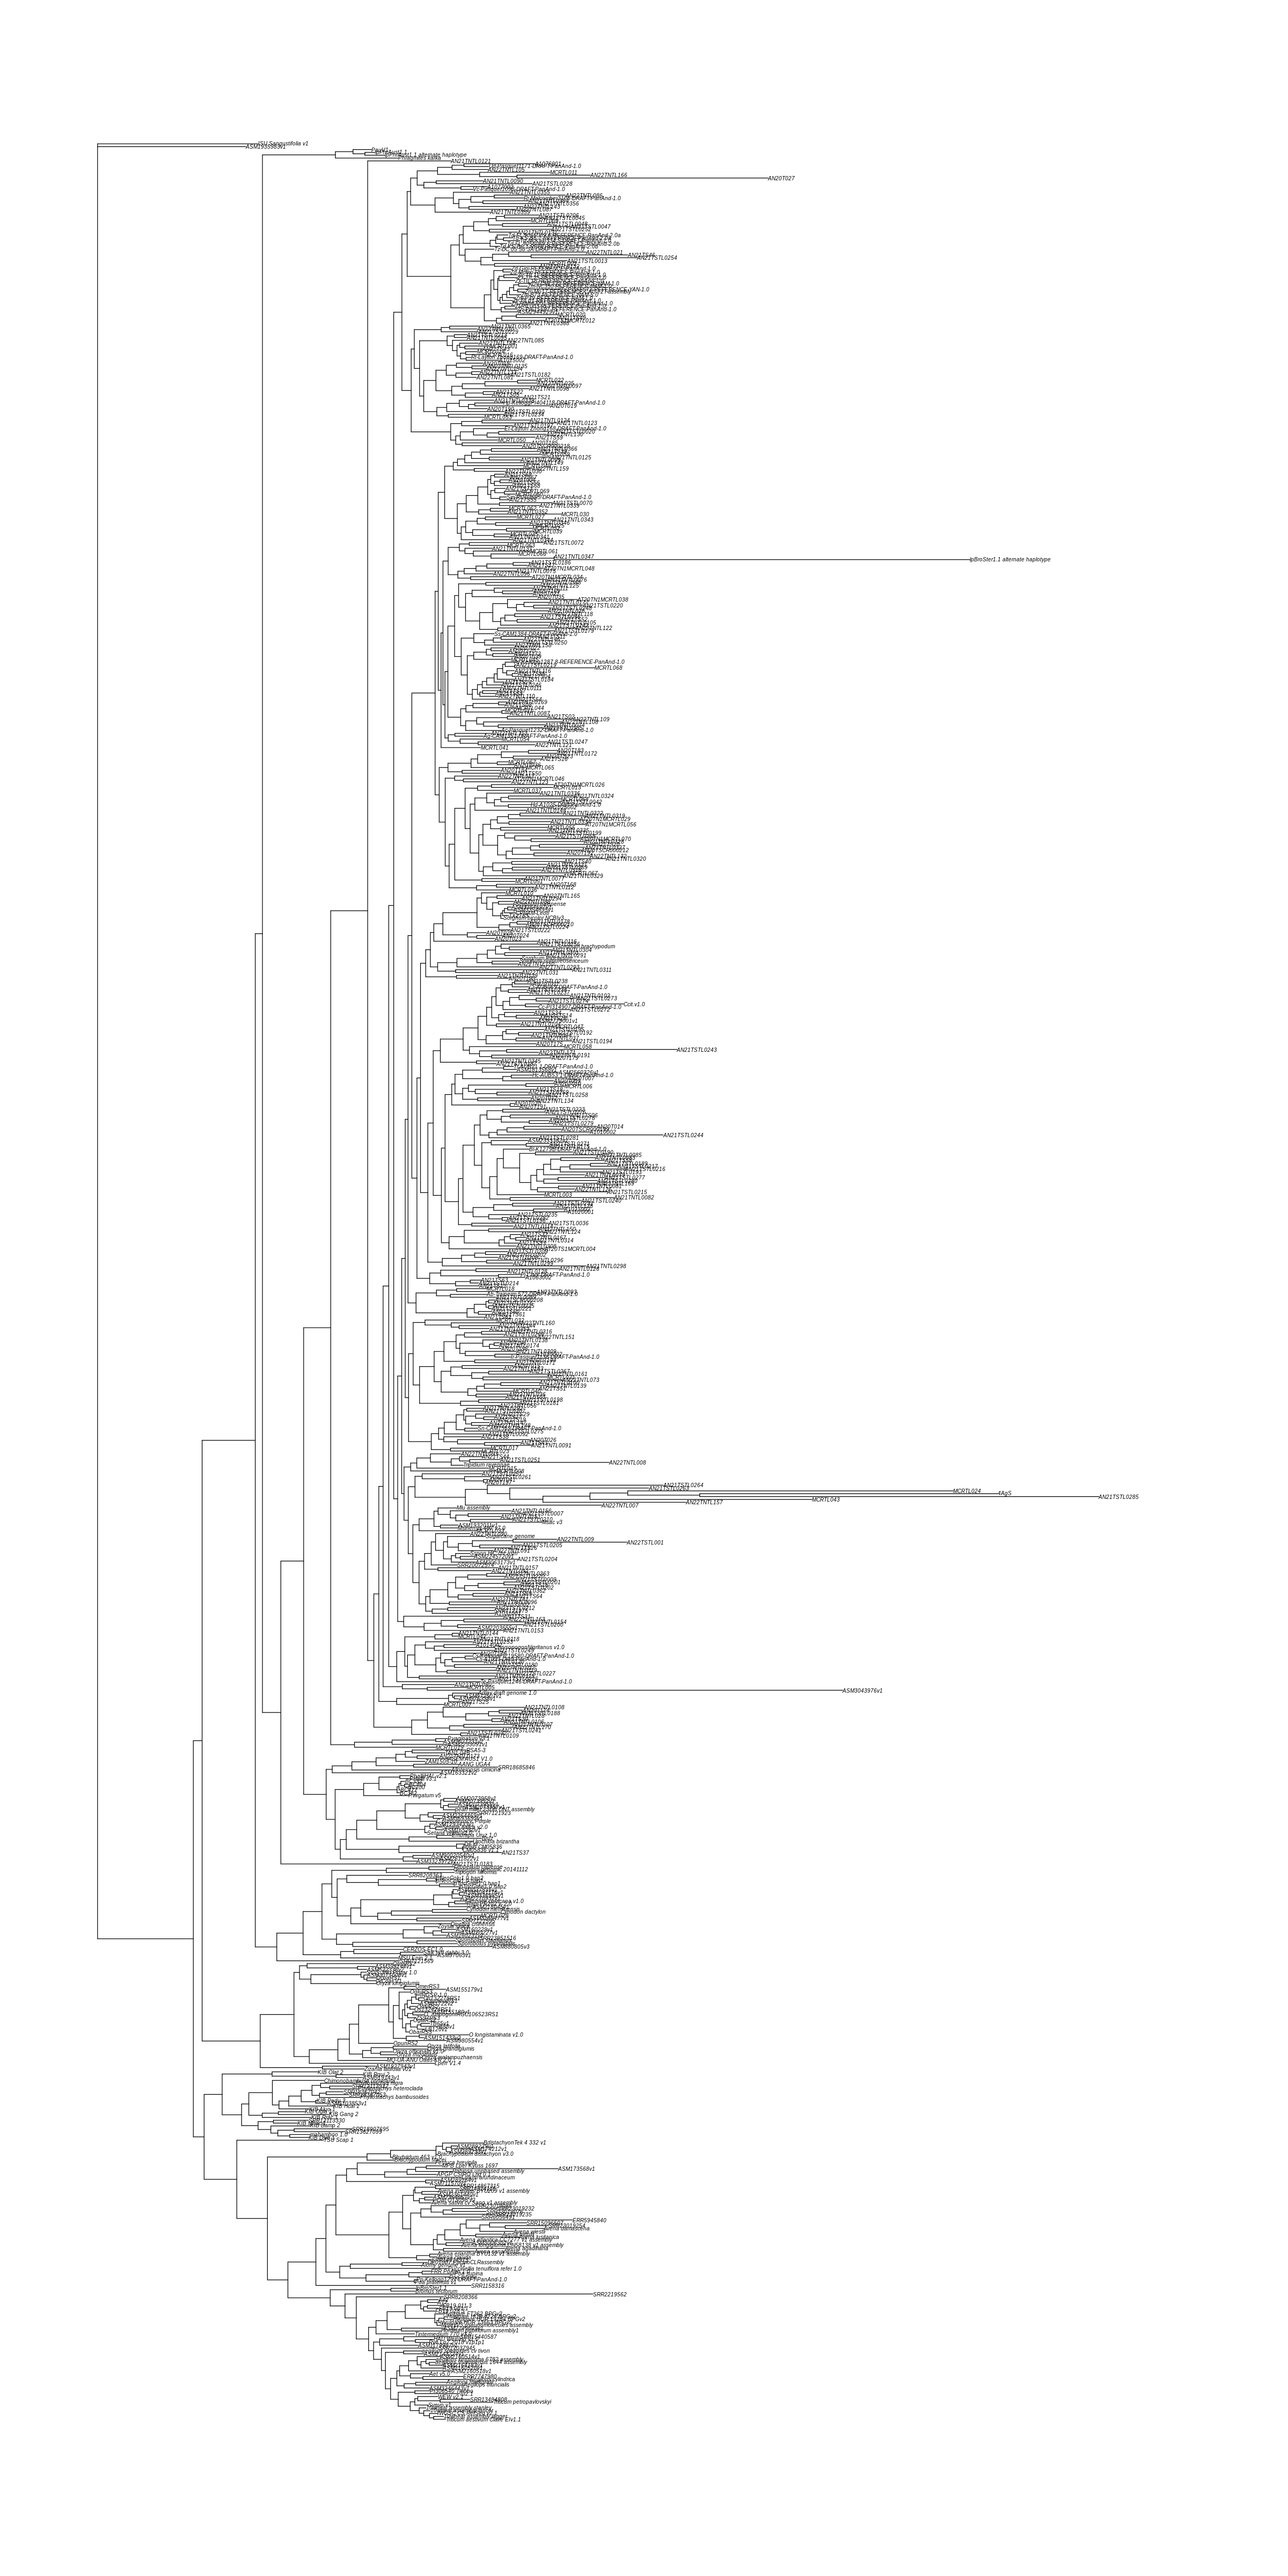

In [39]:
options(repr.plot.width=20, repr.plot.height=40)
plot(nTre.rooted,cex = .5)

In [67]:
ggtree(nTre.rooted,size =1.1,ladderize = T ) + 
geom_tiplab(hjust = -.05,size=3) +
guides(shape = 19) +
theme(legend.position = c(.1,.95),
      legend.text = element_text(size = 10),
      legend.title = element_text(size = 12)) 

In [68]:
png("/workdir/sh2246/p_phyloGWAS/output/neutralTree_v2/RAxML_bestTree.aln_4d_800taxa.png",
    height = 60,width = 20, unit = "cm",pointsize = 6,res = 600)
ggtree(nTre.rooted,size =.5,ladderize = T ) + 
geom_tiplab(hjust = -.05,size=1) +
theme(legend.position = c(.1,.95),
      legend.text = element_text(size = 10),
      legend.title = element_text(size = 12)) 
dev.off()

png 
  2

In [51]:
source("/workdir/sh2246/p_phyloGWAS/src/S01_phyloK.R")


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


Warning message in file(file, "r"):
“cannot open file '/home/sh2246/Dropbox/postDoc/projects/p_phyloGWAS/data/test/test.tree.newick': No such file or directory”


ERROR: Error in file(file, "r"): cannot open the connection


In [52]:
K = phyloK(tree = nTre.rooted)

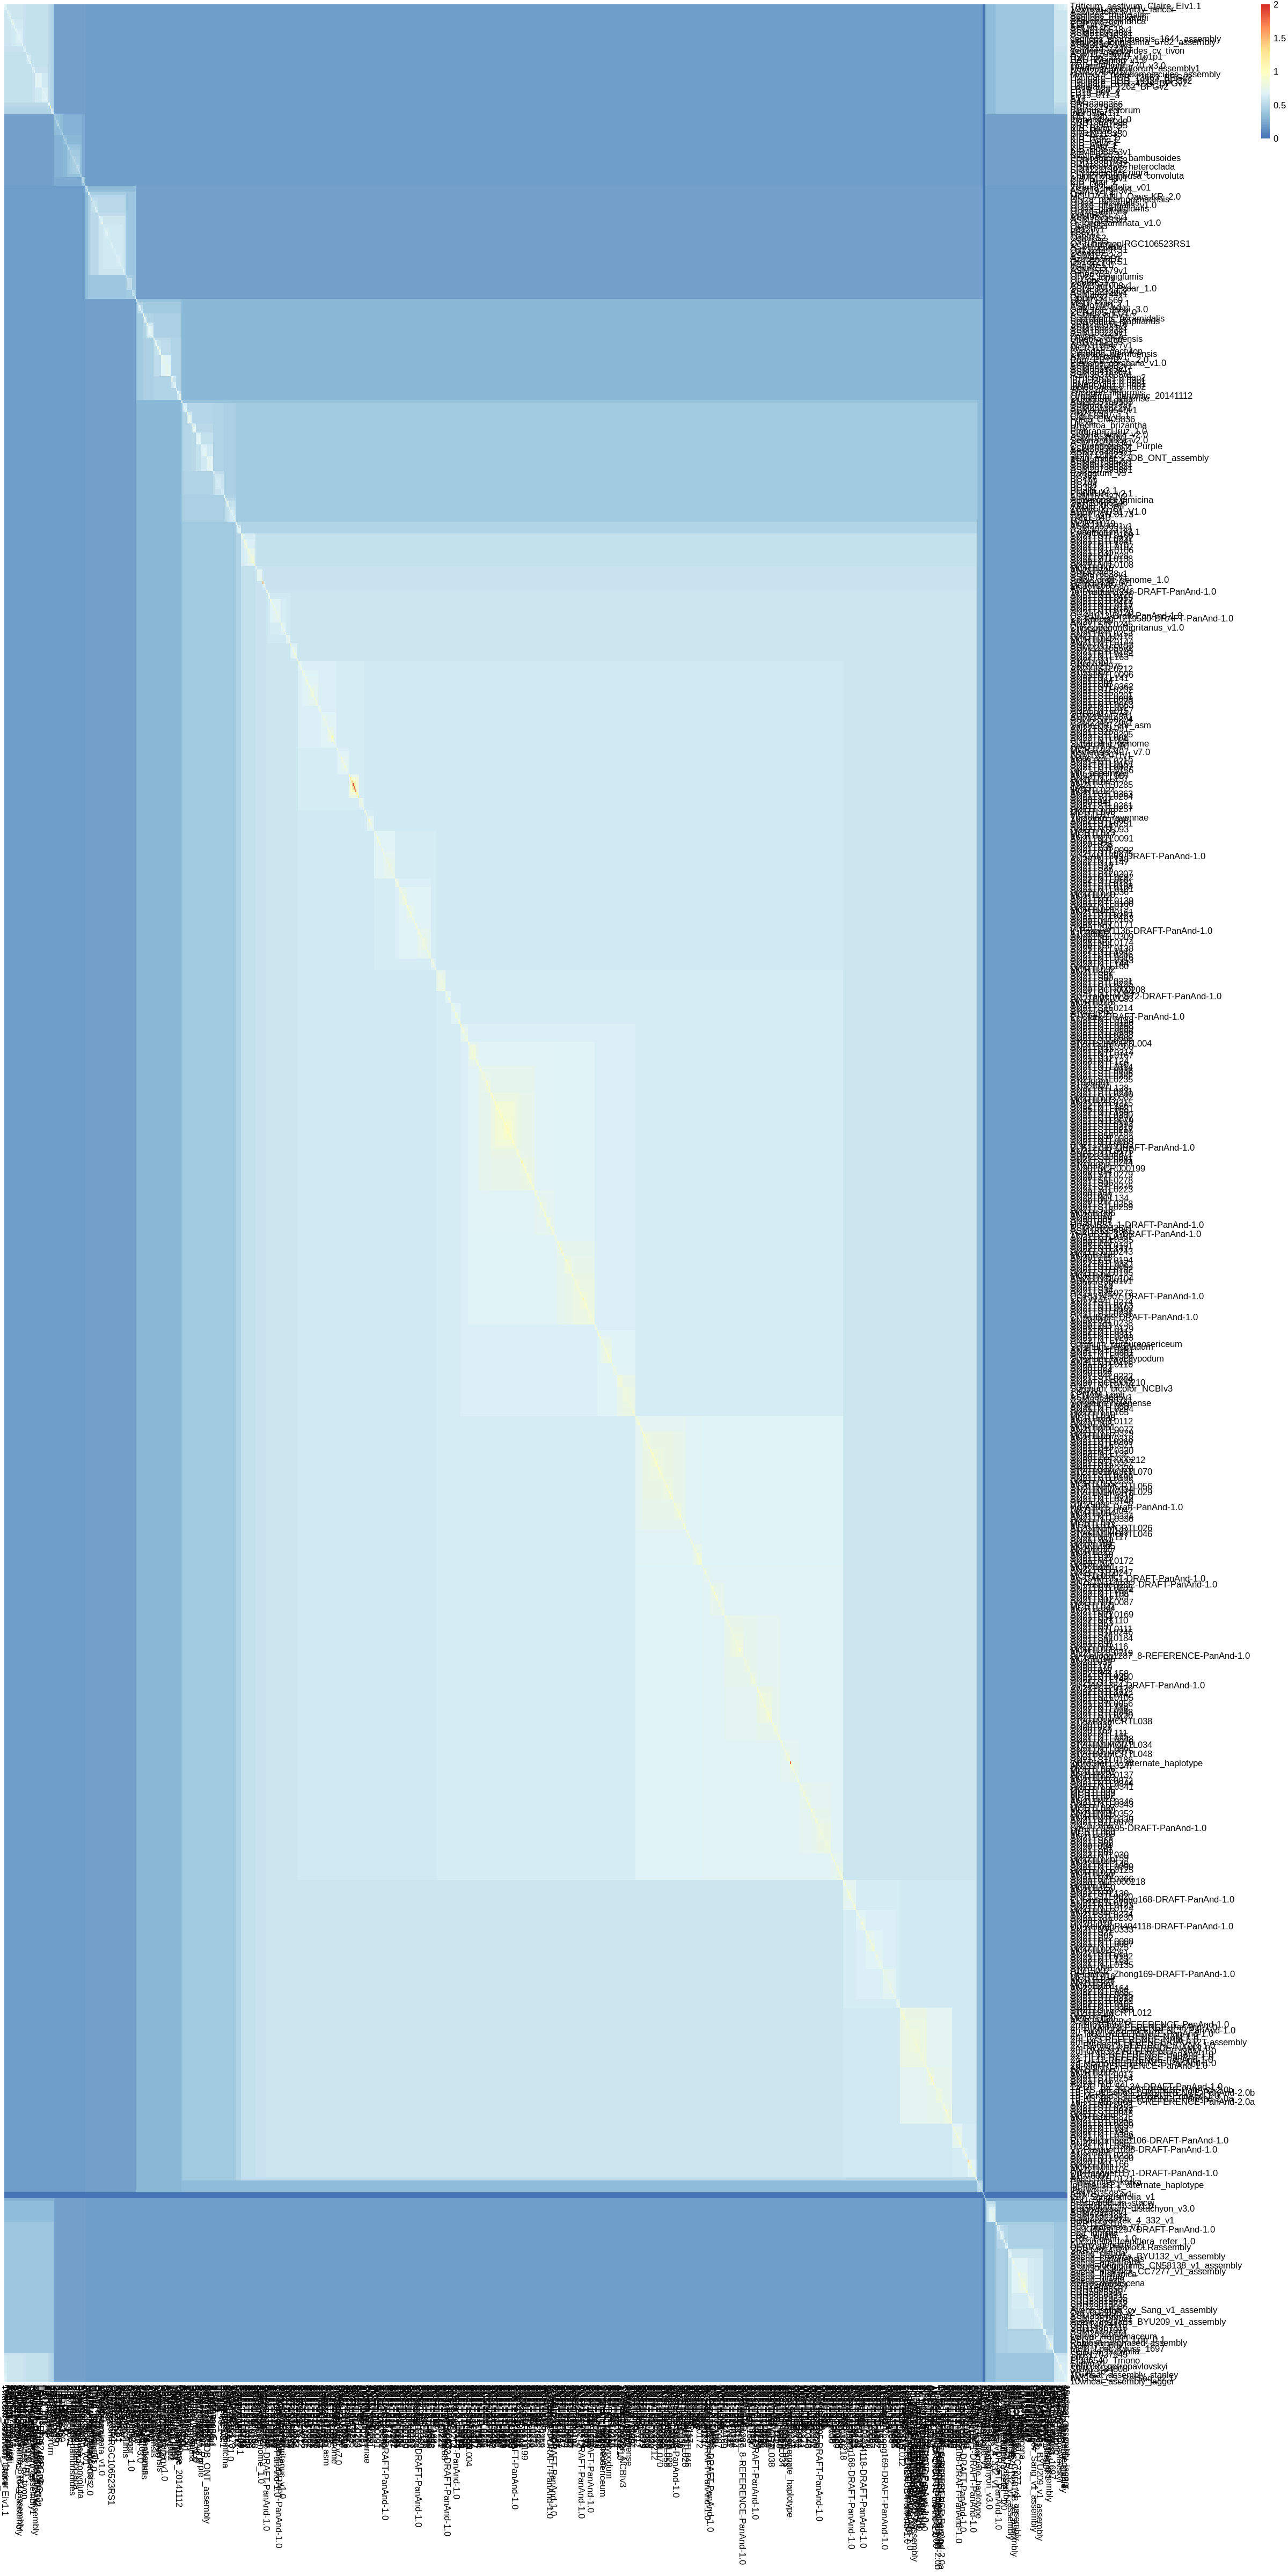

In [53]:
pheatmap(K,cluster_rows = F,cluster_cols = F)

In [24]:
length(retainedSp)

[1] 787

In [64]:
K_filtered = K[retainedSp,retainedSp]

In [65]:
write.table(K,"/workdir/sh2246/p_phyloGWAS/output/phyloK_800Poaceae_4d.txt",sep = "\t",quote = F)

In [57]:
testK = read.table("/workdir/sh2246/p_phyloGWAS/output/phyloK_800Poaceae_4d.txt",row.names = 1)

In [58]:
testK[1:6,1:6]

Triticum_aestivum_Claire_EIv1.1
Triticum_aestivum_Claire_EIv1.1 0.6955575                      
10wheat_assembly_lancer         0.6515418                      
ASM3246443v1                    0.5852913                      
Aegilops_triuncialis            0.5852913                      
Aegilops_markgrafii             0.5852913                      
Aegilops_cylindrica             0.5852913                      
                                X10wheat_assembly_lancer ASM3246443v1
Triticum_aestivum_Claire_EIv1.1 0.6515418                0.5852913   
10wheat_assembly_lancer         0.6643476                0.5852913   
ASM3246443v1                    0.5852913                0.6628487   
Aegilops_triuncialis            0.5852913                0.6124020   
Aegilops_markgrafii             0.5852913                0.6124020   
Aegilops_cylindrica             0.5852913                0.5978599   
                                Aegilops_triuncialis Aegilops_markgrafii
Triticum_aestivum_Claire_EIv1.1 0.5852913            0.5852913          
10wheat_assembly_lancer         0.5852913            0.5852913          
ASM3246443v1                    0.6124020            0.6124020          
Aegilops_triuncialis            0.7317631            0.6354685          
Aegilops_markgrafii             0.6354685            0.6972546          
Aegilops_cylindrica             0.5978599            0.5978599          
                                Aegilops_cylindrica
Triticum_aestivum_Claire_EIv1.1 0.5852913          
10wheat_assembly_lancer         0.5852913          
ASM3246443v1                    0.5978599          
Aegilops_triuncialis            0.5978599          
Aegilops_markgrafii             0.5978599          
Aegilops_cylindrica             0.7433131

In [4]:
metadata = read.csv("/workdir/sh2246/p_phyloGWAS/data/Poaceae_metadata_2024.08.21.csv",header = T)[,c(1,3)]

metadata$spTaxa = paste(metadata[,1],metadata[,2],sep = ":")

In [5]:
head(metadata)

assemblyID                        correctSpecies     
1 ASM2160514v1                      Aegilops bicornis  
2 Aegilops_cylindrica               Aegilops cylindrica
3 SRR2219562                        Aegilops geniculata
4 ASM2160520v1                      Aegilops longissima
5 aegilops_longissima_6782_assembly Aegilops longissima
6 Aegilops_markgrafii               Aegilops markgrafii
  spTaxa                                               
1 ASM2160514v1:Aegilops bicornis                       
2 Aegilops_cylindrica:Aegilops cylindrica              
3 SRR2219562:Aegilops geniculata                       
4 ASM2160520v1:Aegilops longissima                     
5 aegilops_longissima_6782_assembly:Aegilops longissima
6 Aegilops_markgrafii:Aegilops markgrafii

In [69]:
nTre.rooted.renamed=nTre.rooted
merge_tab4=data.frame(assemblyID=rownames(fasta.4d.aln.merged))
merge_tab4=merge(merge_tab4,metadata,by = "assemblyID")
merge_tab4=merge_tab4[!duplicated(merge_tab4$assemblyID),]
rownames(merge_tab4)=merge_tab4$assemblyID
merge_tab4=merge_tab4[nTre.rooted$tip.label,]

nTre.rooted.renamed$tip.label[!is.na(merge_tab4$spTaxa)] = merge_tab4$spTaxa[!is.na(merge_tab4$spTaxa)]

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
plot(nTre.rooted.renamed)
add.scale.bar(x = 0,y = 0,lwd=2)

In [70]:
png("/workdir/sh2246/p_phyloGWAS/output/neutralTree_v2/RAxML_bestTree.aln_4d_800taxa_spLabeled.png",
    height = 60,width = 20, unit = "cm",pointsize = 6,res = 600)
ggtree(nTre.rooted.renamed,size =.5,ladderize = T ) + 
geom_tiplab(hjust = -.05,size=1) +
theme(legend.position = c(.1,.95),
      legend.text = element_text(size = 10),
      legend.title = element_text(size = 12)) 
dev.off()

png 
  2

In [6]:
# astral tree
spTre = read.tree("/workdir/sh2246/p_phyloGWAS/output/PoaceaeTree_angiosperm353_astral.nwk")
spTre.rooted = root(spTre,"ASM1935983v1")
spTre.rooted$edge.length[is.na(spTre.rooted$edge.length)] = 0.01

In [8]:
retainedSp = intersect(metadata[metadata[,2]!="Omit",1],spTre.rooted$tip.label)

In [9]:
spTre.rooted = keep.tip(spTre.rooted,retainedSp)

Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2 3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


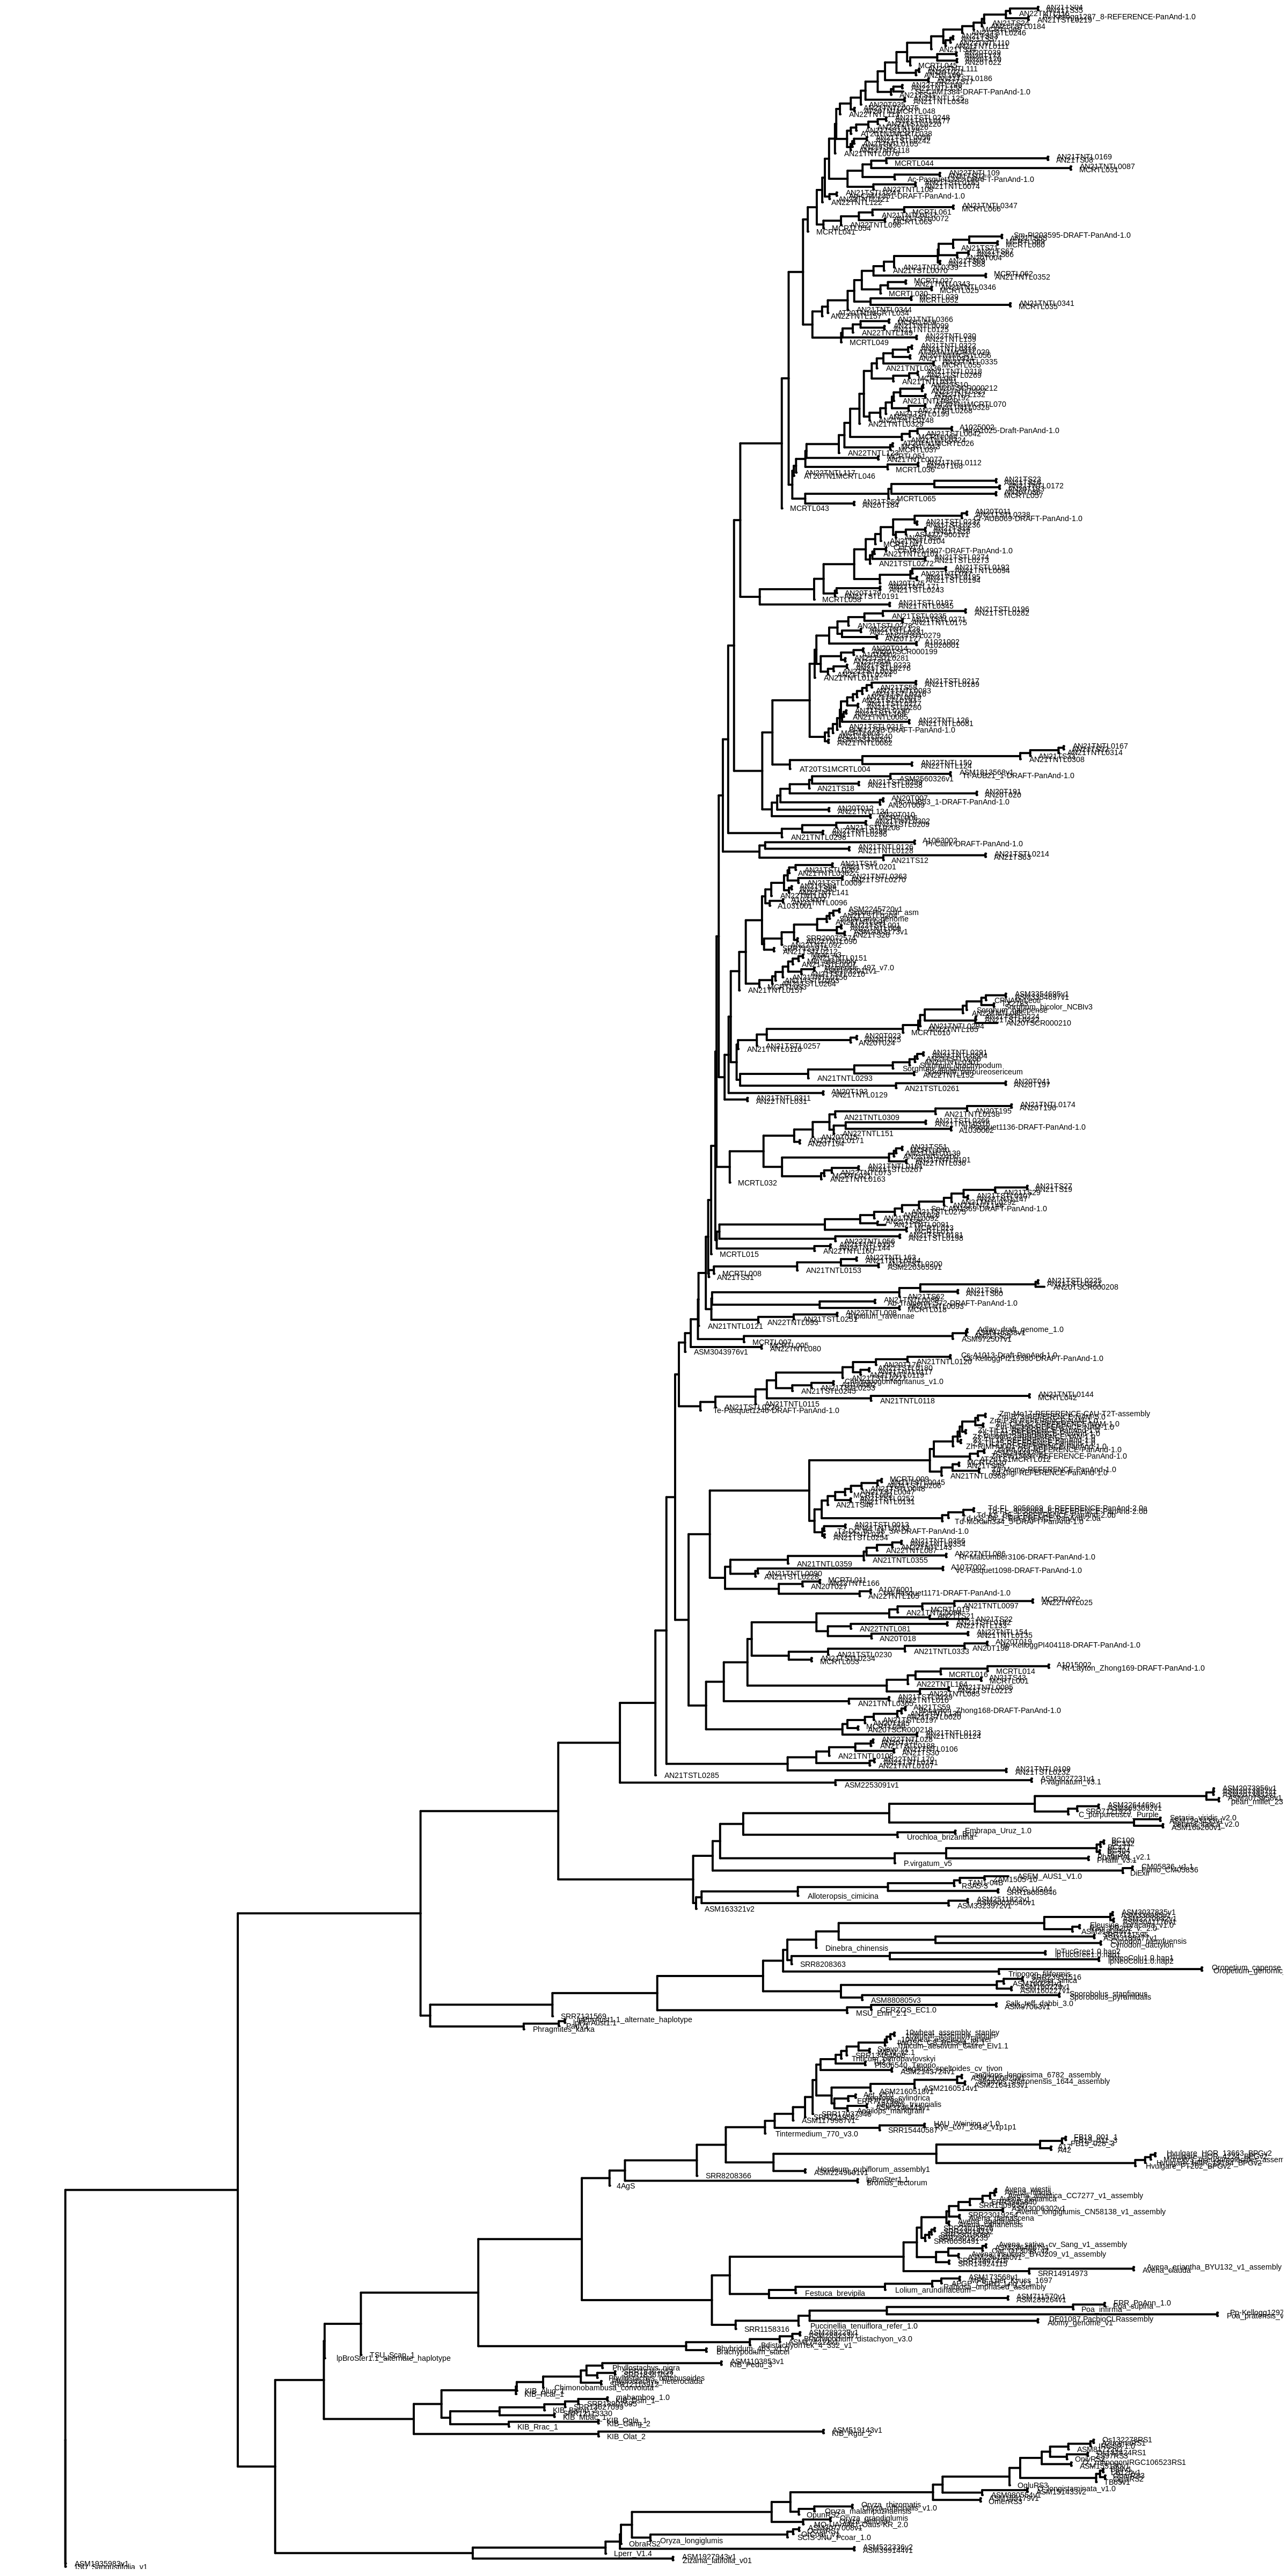

In [10]:
options(repr.plot.width=20, repr.plot.height=40)

ggtree(spTre.rooted,size =1.1,ladderize = T ) + 
geom_tiplab(hjust = -.05,size=3) +
guides(shape = 19) +
theme(legend.position = c(.1,.95),
      legend.text = element_text(size = 10),
      legend.title = element_text(size = 12)) 

In [11]:
spTre.rooted.renamed=spTre.rooted
merge_tab5=data.frame(assemblyID=spTre.rooted$tip.label)
merge_tab5=merge(merge_tab5,metadata,by = "assemblyID")
merge_tab5=merge_tab5[!duplicated(merge_tab5$assemblyID),]
rownames(merge_tab5)=merge_tab5$assemblyID
merge_tab5=merge_tab5[spTre.rooted$tip.label,]

spTre.rooted.renamed$tip.label[!is.na(merge_tab5$spTaxa)] = merge_tab5$spTaxa[!is.na(merge_tab5$spTaxa)]

In [119]:
png("/workdir/sh2246/p_phyloGWAS/output/angiosperm353_astral_spLabeled.png",
    height = 60,width = 20, unit = "cm",pointsize = 6,res = 600)
ggtree(spTre.rooted.renamed,size =.3,ladderize = T ) + 
xlim(c(0,23)) +
geom_tiplab(hjust = -.025,size=1) +
theme(legend.position = c(.1,.95),
      legend.text = element_text(size = 10),
      legend.title = element_text(size = 12)) 
dev.off()

png 
  2

In [18]:
spTre.rooted.renamed$tip.label[grep("diplo",spTre.rooted.renamed$tip.label)]

[1] "Zd-Gigi-REFERENCE-PanAnd-1.0:Zea diploperennis"
[2] "Zd-Momo-REFERENCE-PanAnd-1.0:Zea diploperennis"
[3] "AN21TS49:Zea diploperennis"                    
[4] "MCRTL020:Zea diploperennis"

In [19]:
potInPotSp = c("Zm-B73-REFERENCE-NAM-5.0:Zea mays","Zd-Gigi-REFERENCE-PanAnd-1.0:Zea diploperennis",
               "Sorghum_bicolor_NCBIv3:Sorghum bicolor","Sn-CAM1369-DRAFT-PanAnd-1.0:Sorghastrum nutans",
               "Td-FL_9056069_6-REFERENCE-PanAnd-2.0a:Tripsacum dactyloides",
               "Ag-CAM1351-DRAFT-PanAnd-1.0:Andropogon gerardii",
               "Av-Kellogg1287_8-REFERENCE-PanAnd-1.0:Anatherum virginicum",
               "Bl-K1279B-DRAFT-PanAnd-1.0:Bothriochloa laguroides",
               "Et-Layton_Zhong168-DRAFT-PanAnd-1.0:Elionurus tripsacoides",
               "Ss-CAM1384-DRAFT-PanAnd-1.0:Schizachyrium scoparium",
               "Tt-AUB21_1-DRAFT-PanAnd-1.0:Themeda triandra",
               "A1014002:Chrysopogon zizanioides","Msinensis_497_v7.0:Miscanthus sinensis",
               "P.virgatum_v5:Panicum virgatum")
potInPotTre = keep.tip(spTre.rooted.renamed,potInPotSp)

In [20]:
potInPotTre = root(potInPotTre,"P.virgatum_v5:Panicum virgatum")

In [25]:
potInPotTre$tip.label = limma::strsplit2(potInPotTre$tip.label,":")[,2]

In [33]:
png("/workdir/sh2246/p_phyloGWAS/output/potInPotSpTre.png",
    height = 8.7,width = 8.7, unit = "cm",pointsize = 6,res = 600)
ggtree(potInPotTre,size =1,ladderize = T) + 
geom_tiplab(hjust = -.05,size=3) +
xlim(0,13) +
scale_y_reverse()
dev.off()

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


png 
  2

In [65]:
ZeaTre = keep.tip(spTre.rooted.renamed,spTre.rooted.renamed$tip.label[grep("Zea",spTre.rooted.renamed$tip.label)])

In [66]:
ZeaTre = keep.tip(ZeaTre,c("Zm-B73-REFERENCE-NAM-5.0:Zea mays",'Zx-TIL18-REFERENCE-PanAnd-1.0:Zea mays subsp. mexicana',
                           "Zh-RIMHU001-REFERENCE-PanAnd-1.0:Zea mays subsp . huehuetenangensis",
                           "Zv-TIL11-REFERENCE-PanAnd-1.0:Zea mays subsp. parviglumis"))

In [67]:
ZeaTre$tip.label = limma::strsplit2(ZeaTre$tip.label,":")[,2]

In [68]:
ZeaTre = root(ZeaTre,"Zea mays subsp . huehuetenangensis")

In [82]:
ZeaTre$tip.label[2:3] = ZeaTre$tip.label[c(3,2)]

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


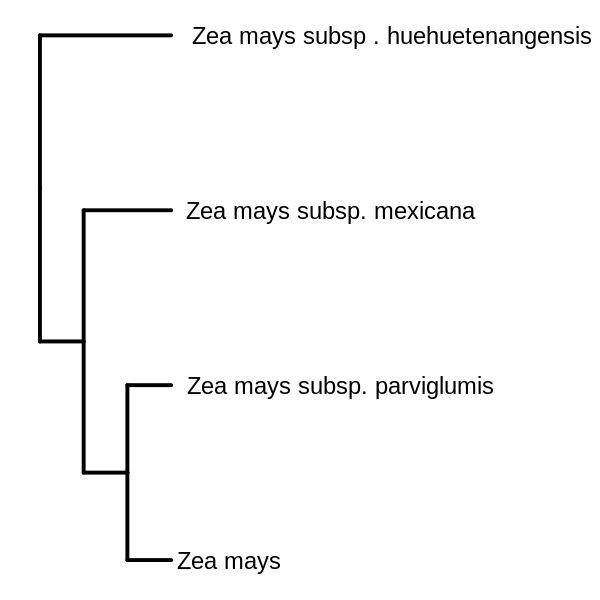

In [83]:
options(repr.plot.width=5, repr.plot.height=5)
ggtree(ZeaTre,size =1.1,ladderize = T ,branch.length = "none") + 
geom_tiplab(hjust = -.05,size=5) +
xlim(0,12) +
scale_y_reverse()

In [120]:
K2 = phyloK(spTre.rooted)

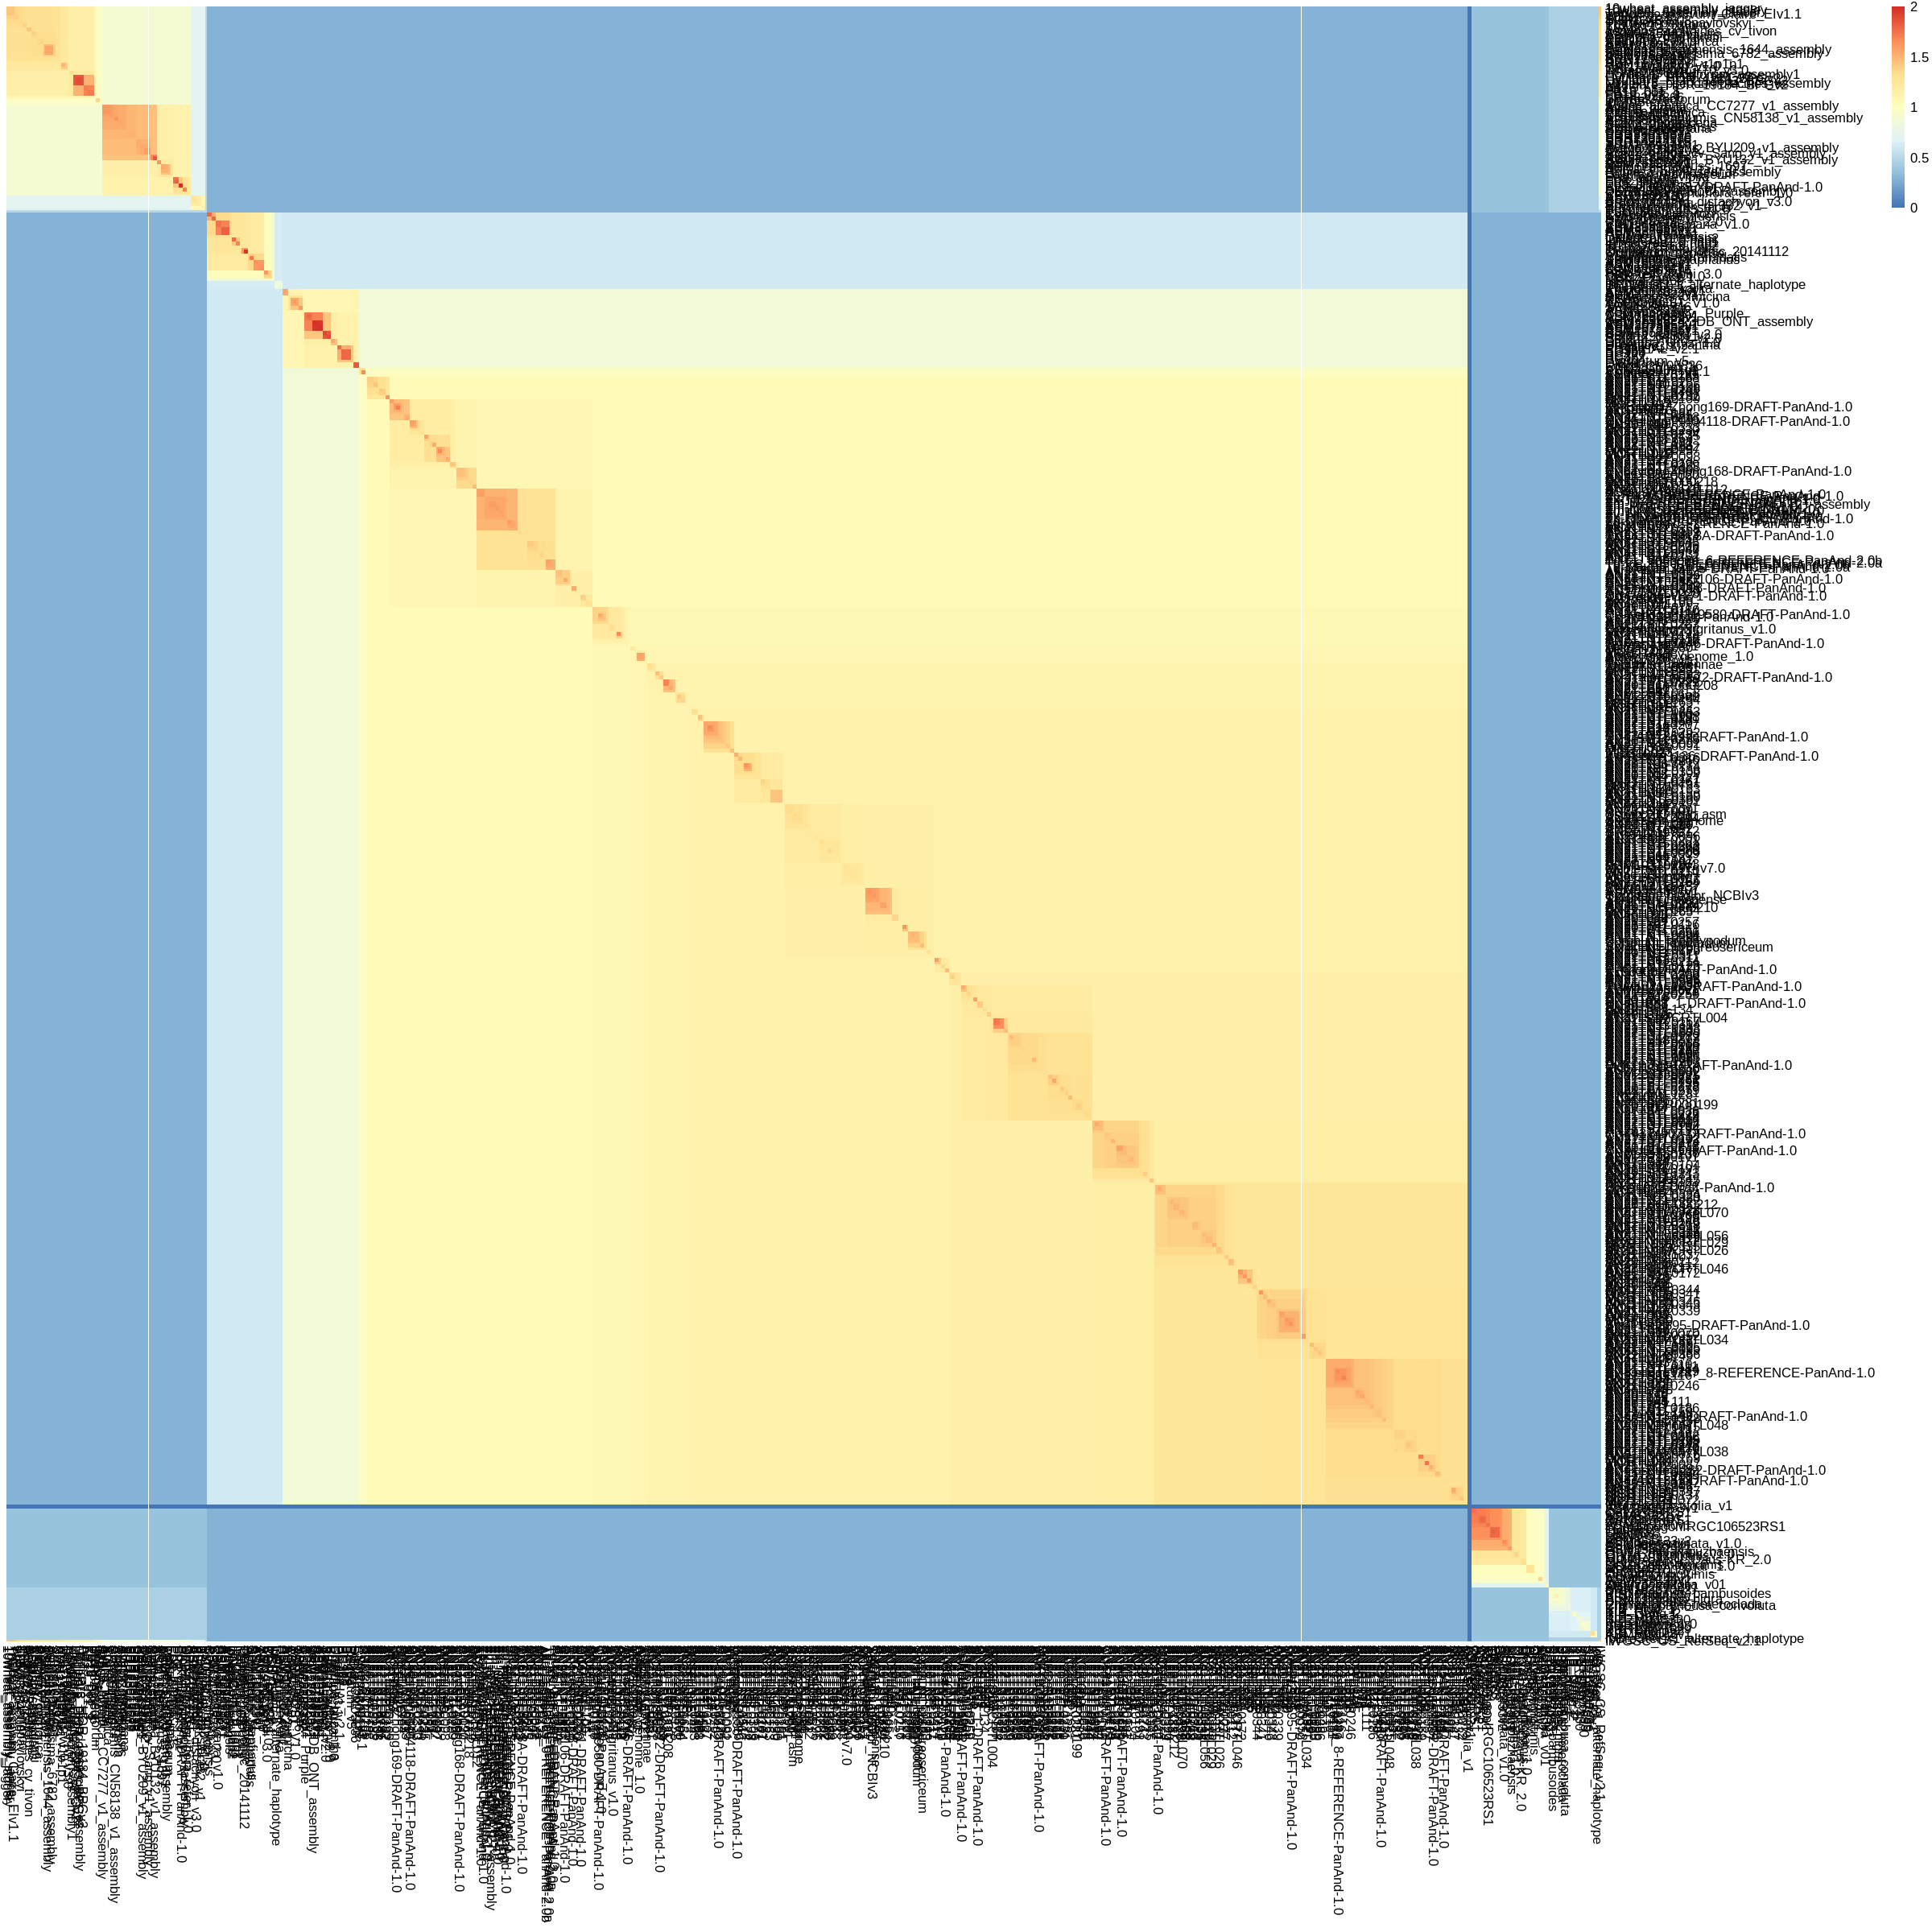

In [121]:
options(repr.plot.width=20, repr.plot.height=20)
pheatmap(K2,cluster_row = F, cluster_col = F)

In [122]:
write.table(K2,"/workdir/sh2246/p_phyloGWAS/output/phyloK_800Poaceae_astral.txt",sep = "\t",quote = F)

In [ ]:
annual=ifelse(nTre.rooted.renamed$tip.label%in%c("A10730002: Thelepogon elegans",
                                          "Mo17: Zea mays","B73: Zea mays","Btx623: Sorghum bicolor"),
             "annual","perennial")

td <- data.frame(node = nodeid(nTre.rooted.renamed, nTre.rooted.renamed$tip.label),
               life_history = annual)
td$node <- as.numeric(td$node)
tree <- full_join(nTre.rooted.renamed, td, by = 'node')

In [ ]:
ggtree(tree,size =1.1,ladderize = T ) + 
geom_tiplab(hjust = -.05,aes(colour = life_history),size=3) +
scale_color_manual(values = c("red","black")) + 
xlim(0,.35) +
guides(shape = 19) +
theme(legend.position = c(.1,.95),
      legend.text = element_text(size = 10),
      legend.title = element_text(size = 12)) 

In [37]:
# NJ tree construction; now move to ML tree using RAxML
D.4d=dist.dna(fasta.4d.aln.merged,pairwise.deletion = T,model = "TN93")
tree.4d=njs(D.4d)
rootedtree.4d=root(tree.4d,outgroup = "REF")

In [ ]:
write.tree(rootedtree.4d,"/workdir/sh2246/p_phyloGWAS/output/neutralTree/4d_NJtree_20231128.nwk")

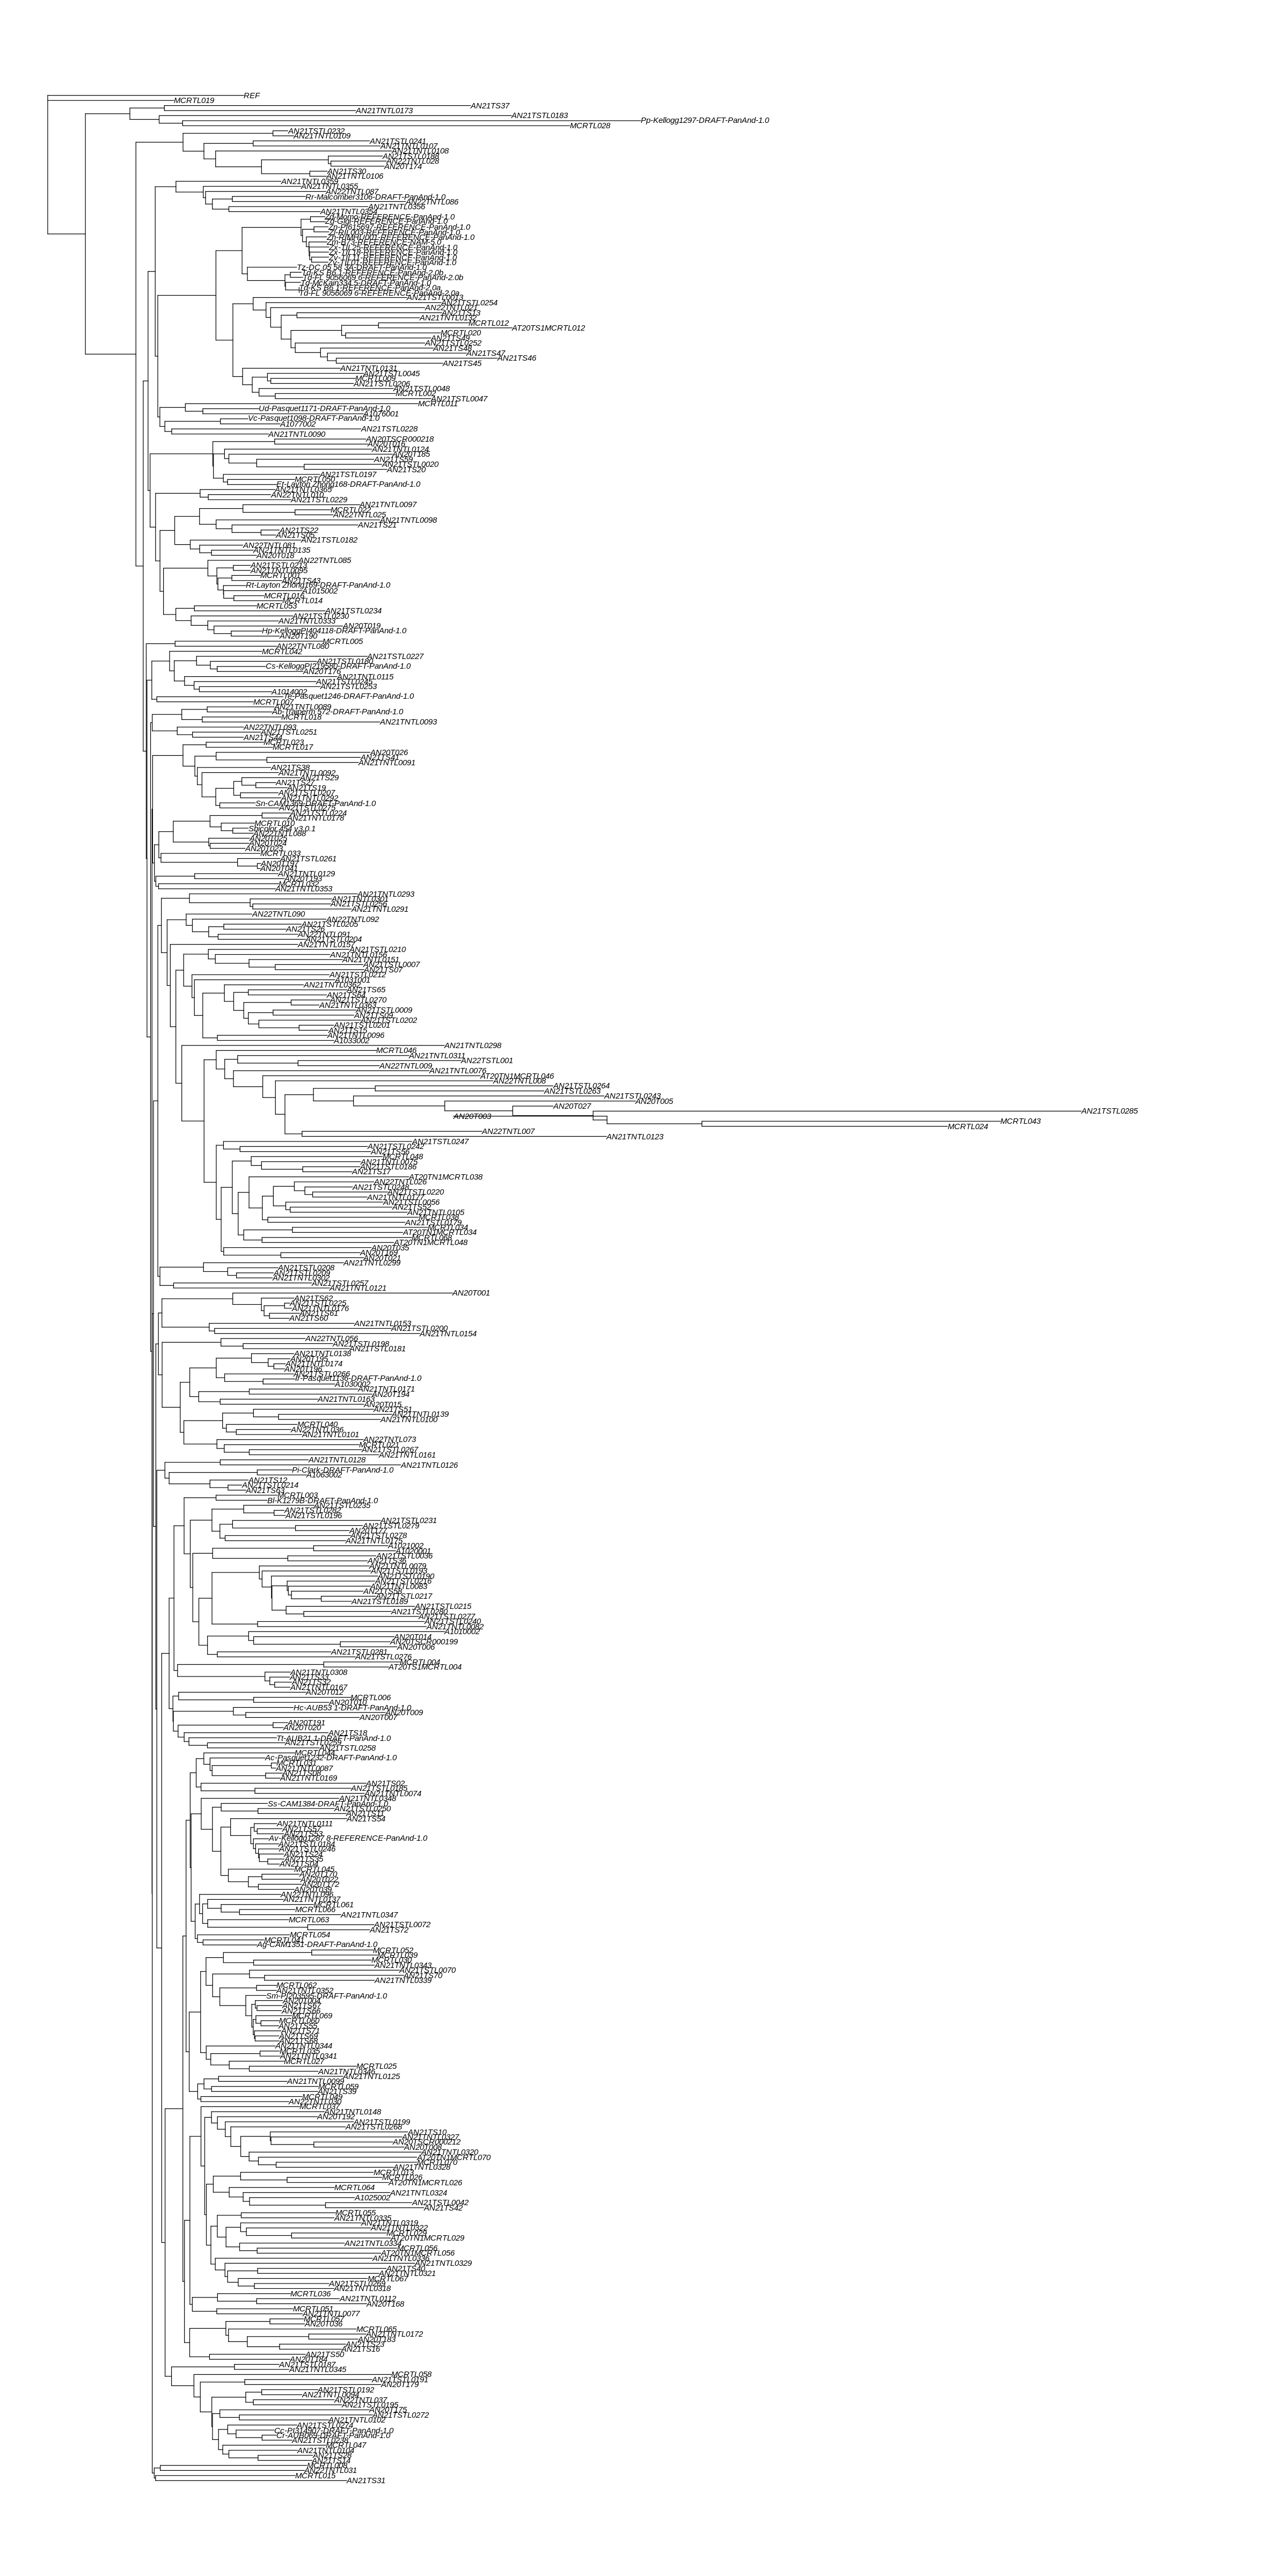

In [38]:
options(repr.plot.width=20, repr.plot.height=40)
plot.phylo(rootedtree.4d,cex = .75,no.margin = T)

In [ ]:
rootedtree.4d.renamed=rootedtree.4d
merge_tab3=data.frame(speciesID=rownames(fasta.4d.aln.merged))
merge_tab3=merge(merge_tab3,metadata,by = "speciesID")
merge_tab3=merge_tab3[!duplicated(merge_tab3$speciesID),]
rownames(merge_tab3)=merge_tab3$speciesID
merge_tab3=merge_tab3[rownames(fasta.4d.aln.merged),]

rootedtree.4d.renamed$tip.label[!is.na(merge_tab3$spTaxa)] = merge_tab3$spTaxa[!is.na(merge_tab3$spTaxa)]

In [ ]:
options(repr.plot.width=20, repr.plot.height=40)
plot(rootedtree.4d.renamed,cex = .75,no.margin = T)
add.scale.bar(x = 0,y = 0,lwd=2)

In [ ]:
# annual=ifelse(rootedtree.4d.renamed$tip.label%in%c("A10730002: Thelepogon elegans",
#                                           "Mo17: Zea mays","B73: Zea mays","Btx623: Sorghum bicolor"),
#              "annual","perennial")

# td <- data.frame(node = nodeid(rootedtree.4d.renamed, rootedtree.4d.renamed$tip.label),
#                life_history = annual)
# td$node <- as.numeric(td$node)
# tree <- full_join(rootedtree.4d.renamed, td, by = 'node')

In [ ]:
ggtree(rootedtree.4d,size =1.1,ladderize = T ) + 
geom_tiplab(size=4) +
# scale_color_manual(values = c("red","black")) + 
xlim(0,.25) +
guides(shape = 19) +
theme(legend.position = c(.1,.95),
      legend.text = element_text(size = 10),
      legend.title = element_text(size = 12)) 

In [ ]:
# distance per transcript
fasta.4d.Dlist=mclapply(fasta.4d.alnm3[sample(1:5000,1000)],function(x) as.matrix(dist.dna(x,pairwise.deletion = T)),mc.cores = getOption("mc.cores", 20L))
# fasta.intron.Dlist=mclapply(fasta.intron.alnm2,function(x) as.matrix(dist.dna(x,pairwise.deletion = T)),mc.cores = getOption("mc.cores", 20L))

fasta.4d.Darray=simplify2array(fasta.4d.Dlist)
fasta.4d.Dmedian=apply(fasta.4d.Darray,MARGIN = c(1,2),function(x) median(x,na.rm=T))

# fasta.intron.Darray=simplify2array(fasta.intron.Dlist)
# fasta.intron.Dmedian=apply(fasta.intron.Darray,MARGIN = c(1,2),function(x) median(x,na.rm=T))


In [ ]:
write.table(fasta.4d.Dmedian,"/workdir/sh2246/p_evolBNI/output/4dDistance_median.txt",sep = "\t",quote = F)

In [ ]:
options(repr.plot.width=6, repr.plot.height=6)
pheatmap(fasta.4d.Dmedian)
hist(fasta.4d.Dmedian[,1])

In [ ]:
avgD=sapply(fasta.4d.Dlist,function(x) mean(x[,1],na.rm = T))

In [ ]:
hist(avgD,xlim=c(0,1),breaks = seq(0,5,0.01))

In [ ]:
tree1=njs(fasta.4d.Dmedian)
# tree1=makeNodeLabel(tree1, method = "number", prefix = "")
# tree2=njs(fasta.intron.Dmedian)
# tree2=makeNodeLabel(tree2, method = "number", prefix = "")

options(repr.plot.width=20, repr.plot.height=40)
# par(mfrow=c(1,2),mar=c(2,2,1,1))
plot(tree1,no.margin = T)
# plot(tree2,show.node.label = T)

In [ ]:
rootedtree1=root(tree1,outgroup = "REF_FULL")
# rootedtree2=root(tree2,outgroup = "AN21TNTL0109")
options(repr.plot.width=20, repr.plot.height=10)
plot(rootedtree1)


In [ ]:
rootedtree1.renamed=rootedtree1
merge_tab=data.frame(Sample=rownames(fasta.4d.alnm2[[1]]))
metadata$Sample=strsplit2(metadata$genome_path,split = "_|.final|.fa")[,1]
metadata$spTaxa=paste0(metadata$Plant_ID,": ",metadata$species.name)
merge_tab=merge(merge_tab,metadata,by = "Sample")
merge_tab=merge_tab[!duplicated(merge_tab$Sample),]
rownames(merge_tab)=merge_tab$Sample
merge_tab=merge_tab[rownames(fasta.4d.alnm2[[1]]),]

rootedtree1.renamed$tip.label[!is.na(merge_tab$spTaxa)] = merge_tab$spTaxa[!is.na(merge_tab$spTaxa)]
rootedtree1.renamed$tip.label[rootedtree1.renamed$tip.label%in%c("Mo17: Zea mays","B73: Zea mays")] = c(": Zea mays (B73)",": Zea mays (Mo17)")
rootedtree1.renamed$tip.label
rootedtree1.renamed$tip.label = limma::strsplit2(rootedtree1.renamed$tip.label,split = ": ")[,2]
options(repr.plot.width=20, repr.plot.height=10)
plot(rootedtree1.renamed)

In [ ]:
annual=ifelse(rootedtree1.renamed$tip.label%in%c("Thelepogon elegans",
                                          "Zea mays (B73)","Zea mays (Mo17)","Sorghum bicolor"),
             "annual","perennial")

td <- data.frame(node = nodeid(rootedtree1.renamed, rootedtree1.renamed$tip.label),
               life_history = annual)
td$node <- as.numeric(td$node)
tree <- full_join(rootedtree1.renamed, td, by = 'node')

In [ ]:

png("/workdir/sh2246/p_evolBNI/output/speciesTrees_median4dD_v2.png",height = 16,width = 16,units = "cm",
    res=600,pointsize = 6)
ggtree(tree,size =1.1,ladderize = T ) + 
geom_tiplab(hjust = -.05,aes(colour = life_history),size=3) +
scale_color_manual(values = c("red","black")) + 
xlim(0,.15) +
guides(shape = 19) +
theme(legend.position = c(.1,.95),
      legend.text = element_text(size = 10),
      legend.title = element_text(size = 12)) 
dev.off()

In [ ]:
write.tree(rootedtree1,"/workdir/sh2246/p_evolBNI/output/speciesTrees_median4dD_v2.newick")

In [ ]:
# # concat MSA for species tree construction
idx=sample(which(substr(strsplit2(fasta.4d.list,"/")[,8],1,20)%in%repTrans.id),5000)
fasta.4d.aln.merged=do.call(cbind, fasta.4d.alnm2[idx])

D.4d=dist.dna(fasta.4d.aln.merged)
tree.4d=njs(D.4d)
rootedtree.4d=root(tree.4d,outgroup = "22")

rootedtree.4d.renamed=rootedtree.4d
merge_tab2=data.frame(Sample=rownames(fasta.4d.alnm2[[1]]))
merge_tab2=merge(merge_tab2,metadata,by = "Sample")
merge_tab2=merge_tab2[!duplicated(merge_tab2$Sample),]
rownames(merge_tab2)=merge_tab2$Sample
merge_tab2=merge_tab2[rownames(fasta.4d.alnm2[[1]]),]

rootedtree.4d.renamed$tip.label[!is.na(merge_tab2$spTaxa)] = merge_tab2$spTaxa[!is.na(merge_tab2$spTaxa)]
options(repr.plot.width=20, repr.plot.height=10)
plot(rootedtree.4d.renamed)

In [ ]:
write.tree(rootedtree.4d,"/workdir/sh2246/p_geneModelEvaluation/output/speciesTrees_finaltaxa_allRepTranscript4dSites.newick")

In [ ]:
# idx4=sapply(fasta.4d.Dlist[idx3],function(x) sum(is.na(x))<1)
# sum(idx4)
# tree.4d.list=mclapply(fasta.4d.Dlist[idx3][idx4],njs,mc.cores = getOption("mc.cores", 20L))

In [ ]:
# library(phytools)
# tree.4d.list.rooted=lapply(tree.4d.list[-c(56,77)],function(x) root(x,outgroup = "AN21TNTL0109"))
# tree.4d.mp=do.call(c,tree.4d.list.rooted)
# tree.4d.mp=lapply(tree.4d.mp,function(x) force.ultrametric(x))
# sptree.4d=speciesTree(tree.4d.mp[-c(4,7,31,59,64)])

# plot(sptree.4d)